In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 20", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

# for fname in ['scf.hdf5','ci.hdf5']:
#     if os.path.isfile(fname):
#         os.remove(fname)

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1


In [3]:
from recipes import ABOPTIMIZE, OPTIMIZE
import importlib, recipes
modules = [recipes]
for m in modules:
    importlib.reload(m)

    # Jastrow optimization
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=4, verbose=False)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

RUNNING VMC OPTIMIZATION


,energy,iteration,error,fname
0,-2.768158,0,0.017573,sj.hdf5
1,-2.879463,1,0.003510,sj.hdf5
2,-2.881067,2,0.005531,sj.hdf5
3,-2.899643,3,0.006911,sj.hdf5


In [8]:
tstep = 0.001
nconfig = 200
nsteps = 2000
discard = 100

In [11]:
#ABDMC
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abdmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
ABDMC("scf.hdf5", "abdmc.hdf5",  load_parameters="sj.hdf5", 
      accumulators = {"energy": True}, verbose=False, 
      nsteps = nsteps,
      tstep= tstep,
      nconfig=nconfig, 
      vmc_warmup=10)

Using spherical guess
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/multiplywf.py(155)gradient()
    153         import pdb
    154         pdb.set_trace()
--> 155         return np.prod(grads, axis=0)
    156 
    157     # MultiplyWF



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/multiplywf.py(155)gradient()
    153         import pdb
    154         pdb.set_trace()
--> 155         return np.prod(grads, axis=0)
    156 
    157     # MultiplyWF



ipdb>  c


ValueError: too many values to unpack (expected 2)

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abdmc.hdf5") as f:
    ee_abdmc = f['energyee'][...]   
    ei_abdmc = f['energyei'][...]
    vh_abdmc = f['energyvh'][...]   
    vxc_abdmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abdmc = f['energyii'][...]    
    ke_abdmc = f['energyke'][...]
    ka_abdmc = f['energyka'][...]
    kb_abdmc = f['energykb'][...]   
    ecorr_abdmc = f['energycorr'][...]    
    etot_abdmc = f['energytotal'][...] 
vhxc_abdmc = vxc_abdmc + vh_abdmc
plt.plot(etot_abdmc, marker='o', label="etot")
# plt.plot(ii_abdmc, marker='o', label="ii")
plt.plot(ee_abdmc, marker='o', label="ee")
plt.plot(ei_abdmc, marker='o', label="ei")
plt.plot(ke_abdmc, marker='o', label="ke")
# plt.plot(ka_abdmc, marker='o', label="ka")
# plt.plot(kb_abdmc, marker='o', label="kb")
plt.plot(vhxc_abdmc, marker='o', label="vhxc")
# plt.plot(ke_abdmc, marker='o', label="ke")

plt.legend()
plt.xlabel("ABDMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABDMC')
for e in [etot_abdmc, ee_abdmc, vh_abdmc, vxc_abdmc, ecorr_abdmc, ei_abdmc, ii_abdmc, ke_abdmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")



Mean  etot_abdmc ,  -2.8950091348026192 +/- 0.005290875500326944
Mean  ee_abdmc ,  0.80187593888703 +/- 0.0028669649410808383
Mean  vh_abdmc ,  3.7557712984113594 +/- 0.01658188041418104
Mean  vxc_abdmc ,  -1.16331176180791 +/- 0.003351014561001345
Mean  ecorr_abdmc ,  -1.1129062359846071 +/- 2.826751577041959e-32
Mean  ei_abdmc ,  -5.89008795712422 +/- 0.2170503223133028
Mean  ii_abdmc ,  0.0 +/- 0.0
Mean  ke_abdmc ,  0.0084806988984069 +/- 0.006158680970686847
LDA Energy,  -2.826706554186113


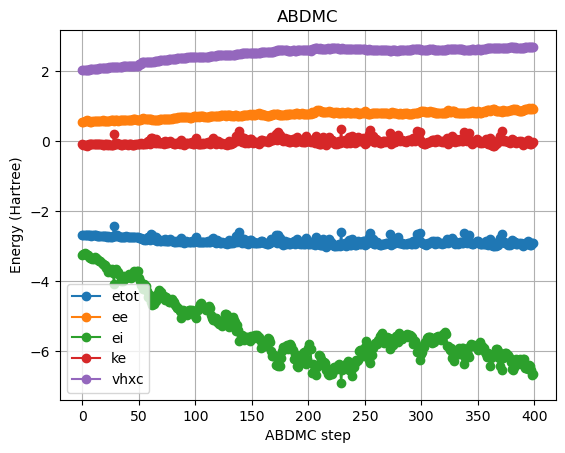

In [51]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abdmc.hdf5") as f:
    ee_abdmc = f['energyee'][...]   
    ei_abdmc = f['energyei'][...]
    vh_abdmc = f['energyvh'][...]   
    vxc_abdmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abdmc = f['energyii'][...]    
    ke_abdmc = f['energyke'][...]
    ka_abdmc = f['energyka'][...]
    kb_abdmc = f['energykb'][...]   
    ecorr_abdmc = f['energycorr'][...]    
    etot_abdmc = f['energytotal'][...] 
vhxc_abdmc = vxc_abdmc + vh_abdmc
plt.plot(etot_abdmc, marker='o', label="etot")
# plt.plot(ii_abdmc, marker='o', label="ii")
plt.plot(ee_abdmc, marker='o', label="ee")
plt.plot(ei_abdmc, marker='o', label="ei")
plt.plot(ke_abdmc, marker='o', label="ke")
# plt.plot(ka_abdmc, marker='o', label="ka")
# plt.plot(kb_abdmc, marker='o', label="kb")
plt.plot(vhxc_abdmc, marker='o', label="vhxc")
# plt.plot(ke_abdmc, marker='o', label="ke")

plt.legend()
plt.xlabel("ABDMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABDMC')
for e in [etot_abdmc, ee_abdmc, vh_abdmc, vxc_abdmc, ecorr_abdmc, ei_abdmc, ii_abdmc, ke_abdmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")



In [53]:
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
import recipes
recipes.DMC("scf.hdf5", "dmc.hdf5",  load_parameters="sj.hdf5", 
    accumulators = {"energy": True}, verbose=False, 
    nsteps =nsteps, tstep= tstep, nconfig=nconfig, vmc_warmup=10)


Mean  etot_dmc ,  -2.903553118184436 +/- 0.0018273183202830153
Mean  ee_dmc ,  0.9230266593914549 +/- 0.001733987119150238
Mean  ei_dmc ,  -6.5955640391177255 +/- 0.07552061775358589
Mean  ke_dmc ,  2.768984261541835 +/- 0.07144965389838115
LDA Energy,  -2.826706554186113


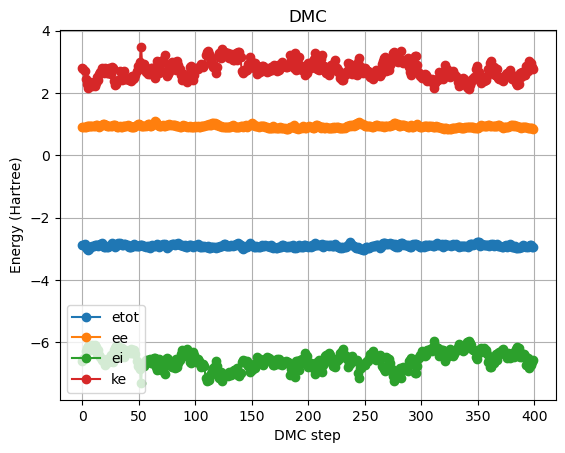

In [54]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("dmc.hdf5") as f:
    etot_dmc = f['energytotal'][...]   
    ee_dmc = f['energyee'][...]   
    ei_dmc = f['energyei'][...]
    ke_dmc = f['energyke'][...]
plt.plot(etot_dmc, marker='o', label="etot")
plt.plot(ee_dmc, marker='o', label="ee")
plt.plot(ei_dmc, marker='o', label="ei")
plt.plot(ke_dmc, marker='o', label="ke")

plt.legend()
plt.xlabel("DMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('DMC')
for e in [etot_dmc, ee_dmc, ei_dmc,ke_dmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")



In [55]:
etot_dmc.shape

(400,)

0.0018273183202830153 0.005290875500326944


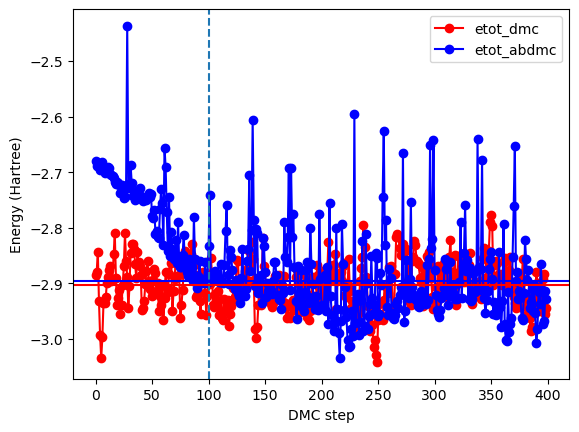

In [56]:
#Compare ABDMC and DMC
plt.plot(etot_dmc, marker='o', color='r', label="etot_dmc")
plt.plot(etot_abdmc, marker='o', color='b', label="etot_abdmc")
plt.legend()
plt.xlabel("DMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()

plt.axvline(discard, linestyle='dashed')
plt.axhline(np.mean(etot_dmc[discard:]), color='r')
plt.axhline(np.mean(etot_abdmc[discard:]), color='b')
plt.grid()
print(np.var(etot_dmc[discard:]),np.var(etot_abdmc[discard:]))
